# Bayes ngram approach for genre classification for BrUK corpus
## Mixed POS-punctuation ngrams as a baseline

In [19]:
from articlehelper import ArticleHandler, RePostprocessor, map_paragraphs, map_category_bruk
import numpy as np
import pandas as pd
import string 
from clfhelpers import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, mutual_info_score, adjusted_mutual_info_score, accuracy_score
from analyzers import PosAnalyzer, PosFreqWordsAnalyzer, Morphology, PosLexAnalyzer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

MASK = 'data\\bruk'
zip_fname = MASK + '.zip'
train_fname = MASK + '_train.txt'
test_fname = MASK + '_test.txt'

In [3]:
train = ArticleHandler.read_zip_list(zip_fname, train_fname, lang='uk')
test = ArticleHandler.read_zip_list(zip_fname, test_fname, lang='uk')
print(len(train), len(test))

262 88


In [4]:
def add_category(articles, map_category):
    for x in articles:
        x['category'] = map_category(x)

add_category(train, map_category_bruk)        
add_category(test, map_category_bruk)

In [5]:
df_train = pd.DataFrame.from_dict(map_paragraphs(train, map_category_bruk))
df_train.groupby(['category']).count()

doc  text
category                
fiction       1480  1480
press         1004  1004
prof_science   825   825

In [6]:
df_test = pd.DataFrame.from_dict(map_paragraphs(test, map_category_bruk))
df_test.groupby(['category']).count()

doc  text
category               
fiction       548   548
press         356   356
prof_science  299   299

In [7]:
X_train = df_train['text'].values
X_test = df_test['text'].values
y_train = df_train['category'].values
y_test = df_test['category'].values

In [8]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

3309 1203 3309 1203


In [26]:
class ClfFactoryPOS:
    def get_analyzer(self):
        return PosAnalyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

factory = ClfFactoryPOS()
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))   

Коли можливості передавання даних у Мережі вдосконалилися до вільного передавання звуку та зображення, почали розвиватися нові види веб-ресурсів. З’явилися прямі трансляції якихось подій, Інтернет-радіо, а також подкасти, почасти схожі на радіо- чи телевізійні передачі в записі.
ДЛЯ НАШОГО ВУХА ДЕЩО НЕЗВИЧНО ЗВУЧИТЬ СКЛАД «ПОД», ТОЖ В УКРАЇНСЬКОМОВНОМУ ІНТЕРНЕТІ ПАРАЛЕЛЬНО ВЖИВАЄТЬСЯ Й ВАРІАНТ «ПІДКАСТИНГ», «ПІДКАСТ». ТАКЕ ПРИСТОСУВАННЯ ТЕРМІНІВ ДО ОРФОЕПІЧНИХ ТРАДИЦІЙ КРАЮ ВІДБУВАЄТЬСЯ ДОСИТЬ ЧАСТО, В РІЗНИХ МОВАХ.
['<P>', '<P>', '<P>', 'PRCL', 'NOUN', 'NOUN', 'ADJF', 'PREP', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', ',', 'VERB', 'VERB', 'ADJF', 'NOUN', 'NOUN', '-', 'NOUN', '.', 'VERB', 'ADJF', 'NOUN', 'NPRO', 'NOUN', ',', 'NOUN', '-', 'NOUN', ',', 'CONJ', 'CONJ', 'NOUN', ',', 'ADVB', 'ADJF', 'INTJ', 'NOUN', '-', 'PRCL', 'ADJF', 'NOUN', 'PREP', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'PREP', 'NPRO', 'NOUN', 'NPRO', 'ADVB', 'VERB', 'NOUN', 'UNDEF

In [27]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [28]:
print(vtrain.shape, vtest.shape)

(3309, 5655) (1203, 5655)


In [29]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.78      0.90      0.83       548
       press       0.59      0.56      0.57       356
prof_science       0.58      0.44      0.50       299

 avg / total       0.67      0.69      0.67      1203

0.25874857960721864


In [30]:
show_all_top_features(tfidf, clf, n=40)

fiction:
<P> <P>: -5.12133663178971
</P> </P>: -5.12133663178971
NOUN ,: -5.1463419125888095
ADJF NOUN: -5.355789608555155
NOUN NOUN: -5.42313192715957
NOUN VERB: -5.423992454438473
NOUN .: -5.439538123052756
VERB NOUN: -5.458603699190761
PRCL VERB: -5.532531745042368
, CONJ: -5.557232993696597
VERB ,: -5.570527086409992
PREP NOUN: -5.624389826203801
NPRO VERB: -5.670429785594461
NPRO NOUN: -5.705677128804396
, PRCL: -5.7634295137888465
VERB .: -5.801778093142145
<P> <P> <P>: -5.813904951646375
</P> </P> </P>: -5.813904951646375
CONJ VERB: -5.929451209474956
. </P> </P> </P>: -5.961250027249359
. </P> </P>: -5.961250027249359
. </P>: -5.961250027249359
ADVB VERB: -6.000425363313578
CONJ NOUN: -6.00221545886124
VERB NPRO: -6.050152153173752
CONJ NPRO: -6.055373185376239
<P> UNDEF: -6.063641451849568
<P> <P> UNDEF: -6.063641451849568
<P> <P> <P> UNDEF: -6.063641451849568
VERB PREP: -6.089329278225257
, VERB: -6.105294910782492
NOUN CONJ: -6.131677706536156
NOUN , CONJ: -6.177551173317115

In [31]:
percentile = 70
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

              precision    recall  f1-score   support

     fiction       0.78      0.90      0.84       548
       press       0.60      0.58      0.59       356
prof_science       0.59      0.44      0.51       299

 avg / total       0.68      0.69      0.68      1203

0.26753224831026684


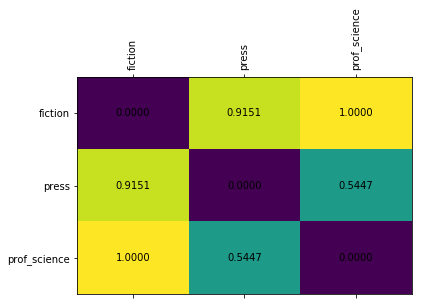

In [32]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [33]:
show_all_top_features(tfidf, clf, n=40)

fiction:
. ADVB VERB NOUN: -5.02423390023325
. ADVB PREP NOUN: -5.02423390023325
ADVB ADVB VERB ,: -5.04923918103235
</P> </P>: -5.258686876998696
CONJ NOUN NPRO PRCL: -5.326029195603111
INTJ CONJ: -5.326889722882013
ADVB PRCL PRCL: -5.342435391496297
NPRO ADVB VERB NOUN: -5.361500967634302
NOUN NOUN -: -5.4354290134859085
, ADJF PREP NOUN: -5.4601302621401375
NOUN VERB CONJ PREP: -5.473424354853533
NOUN NOUN VERB ADVB: -5.527287094647342
NOUN . PRCL ,: -5.5733270540380015
NOUN , NOUN ADJF: -5.608574397247937
, NOUN . NOUN: -5.666326782232387
NOUN VERB UNDEF: -5.704675361585686
. CONJ ,: -5.716802220089916
. ADVB VERB: -5.716802220089916
ADJF PREP NOUN ,: -5.832348477918496
, PRCL PRCL ADVB: -5.8641472956928995
, PRCL PRCL: -5.8641472956928995
, PRCL NPRO VERB: -5.8641472956928995
ADJF . </P> </P>: -5.903322631757119
ADJF NOUN , CONJ: -5.905112727304781
NPRO NOUN CONJ VERB: -5.953049421617292
ADJF NOUN NOUN (: -5.95827045381978
. PRCL: -5.966538720293109
. NOUN ,: -5.966538720293109
. 

In [34]:
df_test = pd.DataFrame.from_dict(test)
df_test.groupby(['category']).count()

alt_orth  author_name  author_name_1  author_name_2  \
category                                                            
fiction             25           24              1              1   
press               44           32              1              1   
prof_science        19           12              4              4   

              author_surname  author_surname_1  author_surname_2  body  \
category                                                                 
fiction                   24                 1                 1    25   
press                     32                 1                 1    44   
prof_science              12                 4                 4    19   

              comments  errors  ...   length  pages  publ_in  publ_part  \
category                        ...                                       
fiction              2      17  ...       25     24        5          1   
press                2      25  ...       44      3       43          4   
prof_science         0      15  ...       19     15       10          8   

              publ_place  publisher  text  title  url  year  
category                                                     
fiction               24         24    25     25    0    25  
press                 30          0    44     44   41    44  
prof_science          17         13    19     19    4    19  

[3 rows x 23 columns]

In [35]:
X_test = df_test['text'].values
y_test = df_test['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.71      1.00      0.83        25
       press       0.84      0.70      0.77        44
prof_science       0.69      0.58      0.63        19

 avg / total       0.77      0.76      0.76        88

0.41010259982438896


In [37]:
from sklearn.externals import joblib
# joblib.dump(clf, 'clf_bruk_MNB_POS.pkl') 
# joblib.dump(tfidf, 'tfidf_bruk_MNB_POS.pkl')
# joblib.dump(sel_perc, 'featsel_bruk_MNB_POS.pkl')

['featsel_bruk_MNB_POS.pkl']

In [3]:
from sklearn.externals import joblib
clf = joblib.load('saves\\clf_bruk_MNB_POS.pkl') 

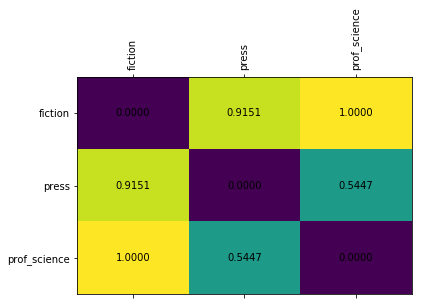

In [4]:
plot_clf_classes_distances(clf)

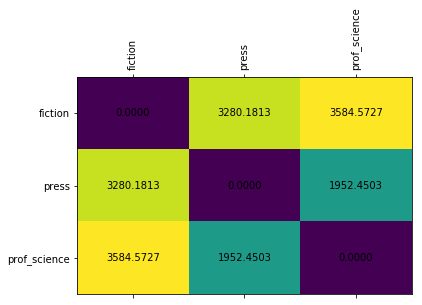

In [5]:
plot_clf_classes_distances(clf, normalization = None)

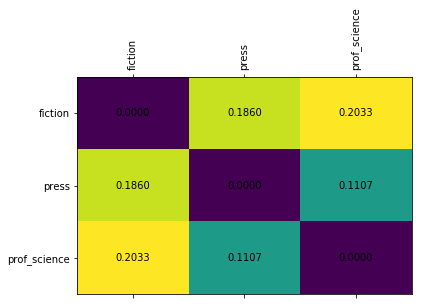

In [6]:
plot_clf_classes_distances(clf, normalization = 'sum')

In [7]:
print(clf.coef_.shape)

(3, 3958)


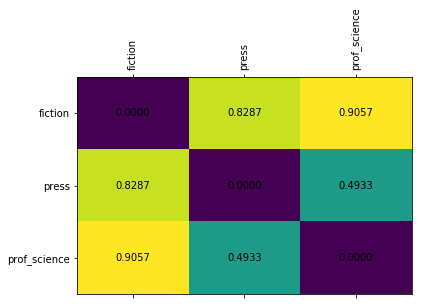

In [8]:
plot_clf_classes_distances(clf, normalization = 'dim')

## Mixed POS-punctuation-frequent words ngrams

In [10]:
class ClfFactoryMix:
    def __init__(self, analyzer=PosFreqWordsAnalyzer(Morphology().getAnalyzer())):
        self.analyzer = analyzer
    
    def get_analyzer(self):
        return self.analyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

freq_words = pd.read_csv('data\\freq_words.txt', sep=' ', header=None, names=['word', 'freq'])['word'].values
print(freq_words)
factory = ClfFactoryMix(PosFreqWordsAnalyzer(Morphology().getAnalyzer(), list(freq_words)))
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))  

['в' 'на' 'і' ... 'середньої' 'доля' 'сподівається']
Коли можливості передавання даних у Мережі вдосконалилися до вільного передавання звуку та зображення, почали розвиватися нові види веб-ресурсів. З’явилися прямі трансляції якихось подій, Інтернет-радіо, а також подкасти, почасти схожі на радіо- чи телевізійні передачі в записі.
ДЛЯ НАШОГО ВУХА ДЕЩО НЕЗВИЧНО ЗВУЧИТЬ СКЛАД «ПОД», ТОЖ В УКРАЇНСЬКОМОВНОМУ ІНТЕРНЕТІ ПАРАЛЕЛЬНО ВЖИВАЄТЬСЯ Й ВАРІАНТ «ПІДКАСТИНГ», «ПІДКАСТ». ТАКЕ ПРИСТОСУВАННЯ ТЕРМІНІВ ДО ОРФОЕПІЧНИХ ТРАДИЦІЙ КРАЮ ВІДБУВАЄТЬСЯ ДОСИТЬ ЧАСТО, В РІЗНИХ МОВАХ.
['<P>', '<P>', '<P>', 'коли', 'можливості', 'NOUN', 'ADJF', 'у', 'NOUN', 'VERB', 'до', 'NOUN', 'NOUN', 'NOUN', 'та', 'NOUN', ',', 'почали', 'VERB', 'нові', 'NOUN', 'NOUN', '-', 'NOUN', '.', 'VERB', 'ADJF', 'NOUN', 'NPRO', 'NOUN', ',', 'NOUN', '-', 'NOUN', ',', 'а', 'також', 'NOUN', ',', 'ADVB', 'ADJF', 'на', 'NOUN', '-', 'чи', 'ADJF', 'NOUN', 'в', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'для', 'NPRO', 'N

In [11]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [12]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.80      0.92      0.85       548
       press       0.62      0.59      0.61       356
prof_science       0.58      0.45      0.51       299

 avg / total       0.69      0.71      0.69      1203

0.29386264198215845


In [ ]:
print(clf.coef_.shape)

In [15]:
percentile = 80
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

              precision    recall  f1-score   support

     fiction       0.79      0.92      0.85       548
       press       0.62      0.58      0.60       356
prof_science       0.58      0.46      0.51       299

 avg / total       0.69      0.70      0.69      1203

0.2893888164947904


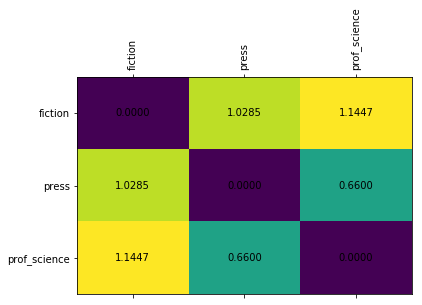

In [16]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [17]:
df_test_doc = pd.DataFrame.from_dict(test)
X_test = df_test_doc['text'].values
y_test = df_test_doc['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.96      1.00      0.98        25
       press       0.87      0.89      0.88        44
prof_science       0.71      0.63      0.67        19

 avg / total       0.86      0.86      0.86        88

0.6380632056658004


In [18]:
print(clf.coef_.shape)

(3, 4201)


In [21]:
print(accuracy_score(y_test, y_predicted))

0.8636363636363636


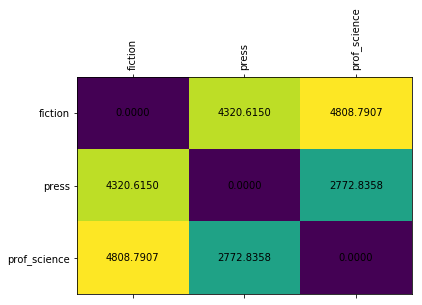

In [27]:
plot_clf_classes_distances(clf, metric='l1', normalization=None)

In [20]:
class ClfFactoryPosLex:
    def __init__(self, analyzer = None, pwf_analyzer=PosFreqWordsAnalyzer(Morphology().getAnalyzer(), lemmatize_freq = True), 
                 lexngrams = None, ngramsize = 2):
        if analyzer is None:
            self.analyzer = PosLexAnalyzer(pwf_analyzer, lexngrams, ngramsize)
        else:
            self.analyzer = analyzer
    
    def get_analyzer(self):
        return self.analyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

freq_words = pd.read_csv('data\\freq_words.txt', sep=' ', header=None, names=['word', 'freq'])['word'].values
lexngrams = np.loadtxt('data\\bruk_bigrams.txt', dtype=object, encoding='utf-8')
print('Lexical ngrams count:', len(lexngrams))
factory = ClfFactoryPosLex(None, PosFreqWordsAnalyzer(Morphology().getAnalyzer(), list(freq_words), lemmatize_freq=True), lexngrams)
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))  

Lexical ngrams count: 2236
Коли можливості передавання даних у Мережі вдосконалилися до вільного передавання звуку та зображення, почали розвиватися нові види веб-ресурсів. З’явилися прямі трансляції якихось подій, Інтернет-радіо, а також подкасти, почасти схожі на радіо- чи телевізійні передачі в записі.
ДЛЯ НАШОГО ВУХА ДЕЩО НЕЗВИЧНО ЗВУЧИТЬ СКЛАД «ПОД», ТОЖ В УКРАЇНСЬКОМОВНОМУ ІНТЕРНЕТІ ПАРАЛЕЛЬНО ВЖИВАЄТЬСЯ Й ВАРІАНТ «ПІДКАСТИНГ», «ПІДКАСТ». ТАКЕ ПРИСТОСУВАННЯ ТЕРМІНІВ ДО ОРФОЕПІЧНИХ ТРАДИЦІЙ КРАЮ ВІДБУВАЄТЬСЯ ДОСИТЬ ЧАСТО, В РІЗНИХ МОВАХ.
['<P>', '<P>', '<P>', 'коли', 'можливість', 'NOUN', 'даний', 'у', 'NOUN', 'VERB', 'до', 'вільний', 'NOUN', 'NOUN', 'та', 'NOUN', ',', 'почати', 'VERB', 'новий', 'вид', 'NOUN', '-', 'NOUN', '.', 'VERB', 'ADJF', 'NOUN', 'якийсь', 'подія', ',', 'інтернет', '-', 'NOUN', ',', 'а', 'також', 'NOUN', ',', 'ADVB', 'схожий', 'на', 'NOUN', '-', 'чи', 'ADJF', 'NOUN', 'в', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'для', 'наш', 'NOUN', 'дещо', 

In [53]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [54]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.79      0.93      0.85       548
       press       0.64      0.60      0.62       356
prof_science       0.60      0.45      0.51       299

 avg / total       0.70      0.71      0.70      1203

0.300698807084498
0.71238570241064


In [55]:
print(clf.coef_.shape)

(3, 5296)


In [56]:
# from sklearn.externals import joblib
# joblib.dump(clf, 'saves\\clf_bruk_MNB_poslex.pkl') 
# joblib.dump(tfidf, 'saves\\tfidf_bruk_MNB_poslex.pkl')


['saves\\tfidf_bruk_MNB_poslex.pkl']

In [57]:
percentile = 90
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

              precision    recall  f1-score   support

     fiction       0.79      0.93      0.86       548
       press       0.63      0.58      0.61       356
prof_science       0.59      0.45      0.51       299

 avg / total       0.69      0.71      0.70      1203

0.30072411270465765
0.7090606816292602


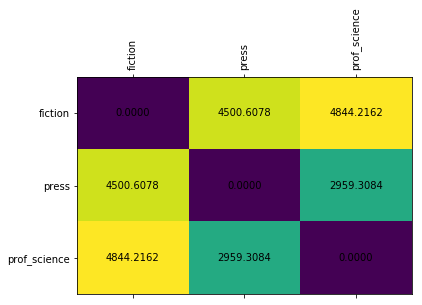

In [58]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [59]:
show_all_top_features(tfidf, clf, n=40)

fiction:
. до NOUN: -4.526256855917488
. для: -4.526256855917488
ADJF NOUN чи: -4.790271404782601
ADVB , що: -4.992450302790942
<P> <P> увесь NOUN: -5.02766243299065
NOUN . NOUN ADVB: -5.18406451860087
NOUN мій: -5.21788340190121
. до той ж: -5.218932237375922
. для NOUN: -5.218932237375922
, щоб NOUN: -5.3560256697181705
, щоб: -5.3560256697181705
, що її: -5.3560256697181705
NOUN новий: -5.357338320043158
NOUN рік: -5.391464351504087
<P> <P>: -5.476506055113012
. спочатку: -5.476506055113012
. звісно ,: -5.476506055113012
NOUN , NOUN: -5.48752864974938
, наче NOUN: -5.623080877189363
в NOUN NOUN NOUN: -5.670118426169986
, NOUN та інший: -5.696917891144294
ADVB -: -5.749757431936086
ADVB , і: -5.749757431936086
: </P>: -5.7682831936506505
. потім: -5.7682831936506505
. за NOUN: -5.7682831936506505
<P> <P> NOUN бути: -5.792561105486252
, GRND ADJF NOUN: -5.813322774370768
багато ADJF: -5.833530160190437
, як на: -5.875687030660016
ADJF NOUN NOUN VERB: -5.883247721458355
<P> <P> як: -5.

In [60]:
print(clf.coef_.shape)

(3, 4236)


In [62]:
clf = joblib.load('saves\\clf_bruk_MNB_poslex.pkl') 
tfidf = joblib.load('saves\\tfidf_bruk_MNB_poslex.pkl') 
df_test_doc = pd.DataFrame.from_dict(test)
X_test = df_test_doc['text'].values
y_test = df_test_doc['category']
vtest = tfidf.transform(X_test)
y_predicted = clf.predict(vtest.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.83      1.00      0.91        25
       press       0.88      0.86      0.87        44
prof_science       0.80      0.63      0.71        19

 avg / total       0.85      0.85      0.85        88

0.5522117237463692
0.8522727272727273


**Conclusion:** best averaged accuracy score for paragraphs from BrUK is 70.9%, for the whole documents accuracy score is 85.22%

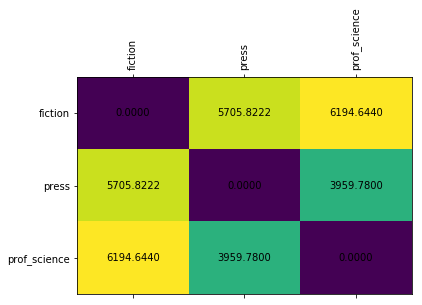

In [63]:
plot_clf_classes_distances(clf, metric='l1', normalization=None)

## Classification of stylistic bigrams using genre classifier

In [88]:
columns = ['bigram', 'predicted']
columns.extend(clf.classes_)
df_ngrams = pd.DataFrame(columns=columns)
for x in lexngrams:
    row = {}
    s = ' '.join(x)
    row['bigram'] = s
    v = tfidf.transform([s])
    row['predicted'] = clf.predict(v)[0]
    for i, p in enumerate(clf.predict_proba(v)[0]):
        row[clf.classes_[i]] = p
    df_ngrams = df_ngrams.append(row, ignore_index=True)
df_ngrams

bigram predicted   fiction     press  prof_science
0             , що   fiction  0.562540  0.244637      0.192823
1              , а   fiction  0.538976  0.247992      0.213032
2           , який   fiction  0.432418  0.329275      0.238307
3              , і   fiction  0.663992  0.184694      0.151314
4             , як   fiction  0.639693  0.212934      0.147373
5              . а   fiction  0.562757  0.265701      0.171541
6              . і   fiction  0.667310  0.214831      0.117859
7            , але   fiction  0.604826  0.206713      0.188461
8           , коли   fiction  0.640565  0.198460      0.160975
9            той ,   fiction  0.779301  0.014715      0.205984
10             . у   fiction  0.382035  0.316631      0.301333
11            , не   fiction  0.652926  0.196121      0.150953
12            , на   fiction  0.540717  0.301211      0.158071
13           , щоб   fiction  0.584032  0.219247      0.196721
14            , де   fiction  0.582951  0.223012      0.194037
15             , у   fiction  0.495169  0.305697      0.199134
16            , бо   fiction  0.720246  0.183113      0.096641
17           . але   fiction  0.603148  0.275418      0.121434
18            . на   fiction  0.476919  0.337423      0.185658
19           <p> у   fiction  0.531438  0.257484      0.211078
20            , то   fiction  0.603794  0.174441      0.221764
21         не бути   fiction  0.573458  0.324904      0.101637
22            те ,   fiction  0.779301  0.014715      0.205984
23             , в   fiction  0.415708  0.350902      0.233390
24             , з   fiction  0.559403  0.271944      0.168653
25            . це     press  0.350263  0.380319      0.269418
26           . він   fiction  0.672362  0.166831      0.160806
27           , хто   fiction  0.438937  0.372473      0.188590
28            , та   fiction  0.767698  0.165422      0.066881
29          , бути   fiction  0.389611  0.337696      0.272693
...            ...       ...       ...       ...           ...
2206         два .   fiction  0.561799  0.247124      0.191077
2207         там і   fiction  0.531438  0.257484      0.211078
2208       за день     press  0.072346  0.806825      0.120829
2209     змогти би   fiction  0.531438  0.257484      0.211078
2210    <p> другий   fiction  0.531438  0.257484      0.211078
2211         раз в   fiction  0.531438  0.257484      0.211078
2212    на хвилина     press  0.355068  0.369325      0.275607
2213        коли ,   fiction  0.733332  0.254547      0.012121
2214  не встигнути   fiction  0.563124  0.305374      0.131502
2215         : хто   fiction  0.531438  0.257484      0.211078
2216     . зрештою   fiction  0.856714  0.035529      0.107757
2217       разом .   fiction  0.755269  0.215839      0.028891
2218         річ .   fiction  0.561799  0.247124      0.191077
2219   хтось інший   fiction  0.531438  0.257484      0.211078
2220     на якийсь     press  0.355068  0.369325      0.275607
2221    не статися   fiction  0.500328  0.343634      0.156038
2222       гроші .   fiction  0.490695  0.111312      0.397993
2223        . отож   fiction  0.531438  0.257484      0.211078
2224      кінець .   fiction  0.561799  0.247124      0.191077
2225      від день   fiction  0.531438  0.257484      0.211078
2226       , стати   fiction  0.531438  0.257484      0.211078
2227  реагувати на   fiction  0.531438  0.257484      0.211078
2228      рідний ,   fiction  0.531438  0.257484      0.211078
2229     може мати   fiction  0.531438  0.257484      0.211078
2230    інтернет -     press  0.188671  0.406689      0.404641
2231  частина мова   fiction  0.531438  0.257484      0.211078
2232    допомога ,   fiction  0.531438  0.257484      0.211078
2233    свій місце   fiction  0.531438  0.257484      0.211078
2234   замість той   fiction  0.531438  0.257484      0.211078
2235        досі ,   fiction  0.531438  0.257484      0.211078

[2236 rows x 5 columns]

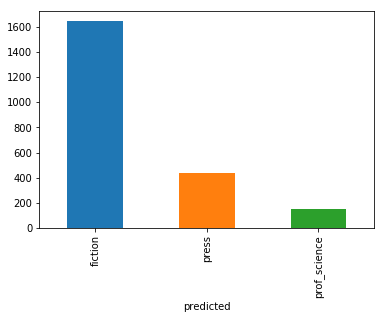

In [107]:
counts = df_ngrams.groupby('predicted').count()['bigram']
counts.plot(kind='bar')

# Testing  Universal Dependencies for Ukrainian

In [11]:
from collections import OrderedDict
from conllu import parse
PATH = "C:\\work\\jul\\prj-nlp\\students\\juliamakogon\\task_08\\data\\UD_Ukrainian-IU-master\\UD_Ukrainian-IU-master"
with open(PATH + "\\uk_iu-ud-train.conllu", "r", encoding='utf-8') as f:
    data = f.read()
train_trees = parse(data)
print(len(train_trees))

4513


In [14]:
def tree2text(tree):
    tokens = [x['form'] for x in tree]
    return ' '.join(tokens)

X = []
for tree in train_trees:
    X.append(tree2text(tree))
print(len(X))

4513


In [21]:
from sklearn.externals import joblib
clf = joblib.load('saves\\clf_bruk_MNB_poslex.pkl') 
tfidf = joblib.load('saves\\tfidf_bruk_MNB_poslex.pkl') 
vtest = tfidf.transform(X)
y_ud = clf.predict(vtest.toarray())

In [36]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 2000)
df_ud = pd.DataFrame({'text':X, 'predicted':y_ud})
df_ud

predicted                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text
0     prof_science                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            У домі римського патриція Руфіна була прегарна фреска , зображення Венери та Адоніса .
1            press                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Якось зібралися у нього , ховаючися від переслідувань , одновірці дружини — християнки .
2          fiction                                                                                        

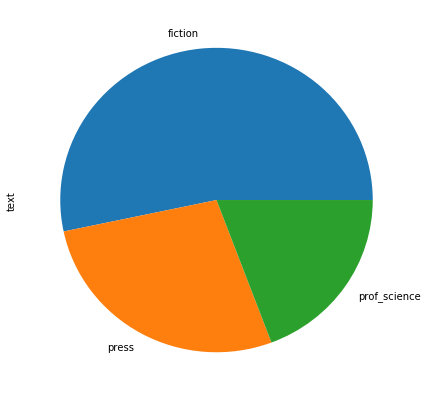

In [34]:
counts = df_ud.groupby('predicted').count()['text']
counts.plot(kind='pie', figsize=(7, 7))